### Density Estimation 

- Following Manski et al.(2009)
- Three cases 
   - case 1. 3+ intervales with positive probabilities, to be fitted with a generalized beta distribution
   - case 2. exactly 2 adjacent intervals with positive probabilities, to be fitted with a triangle distribution 
   - case 3. one interval only, to be fitted with a uniform distribution

In [1]:
from scipy.stats import gamma
from scipy.stats import beta 
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import numpy as np
import pandas as pd

### Case 1. Generalized Beta Distribution

In [2]:
def GeneralizedBetaEst(bin,probs):
    """
    This fits a histogram with positive probabilities in at least 3 bins to a generalized beta distribution.
    Depending on if there is open-ended bin on either side with positive probability, 
       the estimator decides to estimate 2 or 4 parameters, respectively. 
       
    paramters
    ---------
    bin:  ndarray, (n+1) x 1 
          positions for n bins in the histograms 
          
    probs:  ndarrray n x 1
          each entry is a probability for each of the n bins given by the surveyee, between 0 and 1
                 
    returns
    -------
    moments:  ndarray of 2 or 4  
              2:  alpha and beta 
              4:  alpha, beta, lb, ub, e.g. lb=0 and ub=1 for a standard beta distribution
    """
    # n+1 bins and n probs, both are arrays
    if sum([probs[i]>0 for i in range(len(bin)-1)])<3:
        print("Warning: at least three bins with positive probs are needed")
        para_est=[]
    if sum(probs)!=1:
        print("probs need to sum up to 1")
        para_est=[]
    else:
        cdf = np.cumsum(probs)
        pprob=[i for i in range(len(bin)-1) if probs[i]>0]
        lb=bin[min(pprob)]
        print("lower bound is "+str(lb))
        ub=bin[max(pprob)+1]
        print("upper bound is "+str(ub))
        x0_2para = (2,1)
        x0_4para = (2,1,0,1) 
        def distance2para(paras2): # if there is no open-ended bin with positive probs 
            a,b=paras2
            distance= sum((beta.cdf(bin[1:],a,b,loc=lb,scale=ub-lb)-cdf)**2)
            return distance
        def distance4para(paras4): # if either on the left or right side one open-ended bin is with postive probs
            a,b,lb,ub=paras4
            distance= sum((beta.cdf(bin[1:],a,b,loc=lb,scale=ub-lb)-cdf)**2)
            return distance
        if lb==bin[0] and ub==bin[-1]:
            para_est = minimize(distance4para,x0_4para,method='CG')['x']
        else:
            para_est = minimize(distance2para,x0_2para,method='CG')['x']
        return para_est   # could be 2 or 4 parameters 

In [3]:
def GeneralizedBetaStats(alpha,beta,lb,ub):
    """
    This function computes the moments of a generalized beta distribution, mean and variance for now. 
    
    parameters
    ----------
    alpha, beta, lb, ub: floats 
    
    returns
    -------
    dict:  2 keys
           mean, float 
           variance, float 
           std, float 
           irq1090, float  
    """
    # lb=0 and ub=1 for a standard beta distribution
    mean = lb + (ub-lb)*alpha/(alpha+beta)
    var = (ub-lb)**2*alpha*beta/((alpha+beta)**2*(alpha+beta+1))
    std = np.sqrt(var)
    x = np.linspace(beta.ppf(0.01, a, b), beta.ppf(0.99, a, b), 100)
    quantiles = quantile(x,[0.1, 0.9])
    irq1090 = quantiles[0]/quantiles[1]
    return {"mean": mean,"variance":var, "std": std, "irq1090": irq1090}

### Case 2. Isosceles Triangle distribution

Two adjacent intervales $[a,b]$,$[b,c]$ are assigned probs $\alpha$ and $1-\alpha$, respectively. In the case of $\alpha<1/2$, we need to solve parameter $t$ such that $[b-t,c]$ is the interval of the distribution. Denote the height of the trangle distribution $h$. Then following two restrictions need to satisfy

\begin{eqnarray}
\frac{t^2}{t+c-b} h = \alpha \\
(t+(c-b))h = 2
\end{eqnarray}

The two equations can solve $t$ and $h$

$$\frac{t^2}{(t+c-b)^2}=\alpha$$

$$t^2 = \alpha t^2 + 2\alpha t(c-b) + \alpha(c-b)^2$$

$$(1-\alpha) t^2 - 2\alpha(c-b) t - \alpha(c-b)^2=0$$

$$\implies t =\frac{2\alpha(c-b)+\sqrt{4\alpha^2(c-b)^2+4(1-\alpha)\alpha(c-b)^2}}{2(1-\alpha)} = \frac{\alpha(c-b)+(c-b)\sqrt{\alpha}}{(1-\alpha)}$$

$$\implies h = \frac{2}{t+c-b}$$


In [4]:
def TriangleEst(bin,probs):
    """
    The function fits histograms with exactly two adjacent 
       bins with positive probabilitie to a triangular distribution.
    It genetes the bounds of the isoceles triangle distribution. 
    
    paramters
    ---------
    bin:  ndarray, (n+1) x 1 
          positions for n bins in the histograms 
          
    probs:  ndarrray n x 1
          each entry is a probability for each of the n bins given by the surveyee, between 0 and 1
    
    returns
    --------
    dict: 3 keys
          lb: float, left bound 
          ub: float, right bound
          h:  float, height of the triangle
          c: float, mode
    
    """
    if sum([probs[i]>0 for i in range(len(bin)-1)])==2:
        print("There are two bins with positive probs")
        pprobadj = [i for i in range(1,len(bin)-3) if probs[i]>0 and probs[i+1]>0]   # from 1 to -3 bcz excluding the open-ended on the left/right
        if sum(pprobadj)>0:
            print('The two intervals are adjacent and not open-ended')
            min_i = min(pprobadj)
            #print(min_i)
            #print(probs[min_i])
            #print(probs[min_i+1])
            #print(pprobadj[0])
            #print(pprobadj[0]+2)
            #print(probs[min_i] > probs[min_i+1])
            #print(bin[pprobadj[0]])
            #print(bin[pprobadj[0]+2])
            if probs[min_i] > probs[min_i+1]:
                alf = probs[min_i+1]
                lb = bin[pprobadj[0]]
                scl = bin[pprobadj[0]+1]-bin[pprobadj[0]]
                t = scl*(alf/(1-alf) +np.sqrt(alf)/(1-alf))
                ub = bin[pprobadj[0]+1]+t 
                h = 2/(t+bin[pprobadj[0]+1]-bin[pprobadj[0]])
                c = ub - 2/h
            if probs[min_i] < probs[min_i+1]:
                alf = probs[min_i]
                ub = bin[pprobadj[0]+2]
                scl = bin[pprobadj[0]+2]-bin[pprobadj[0]+1]
                t = scl*(alf/(1-alf) + np.sqrt(alf)/(1-alf))
                lb = bin[pprobadj[0]+1]-t  
                h = 2/(t+bin[pprobadj[0]+2]-bin[pprobadj[0]+1])
                c = ub - 2/h
            if probs[min_i] == probs[min_i+1]:
                ub=bin[pprobadj[0]]
                lb=bin[pprobadj[0]+2]
                h = 2/(ub-lb)
                c = ub - 2/h
        else:
            lb = []
            ub = []
            h = []
            c = []
            print('Warning: the two intervals are not adjacent or are open-ended')
    return {'lb':lb,'ub':ub,"height":h,"mode":c}

#### pdf of a triangle distribution

\begin{eqnarray}
f(x)= & 1/2(x-lb) \frac{x-lb}{(ub+lb)/2}h \quad \text{if } x <(lb+ub)/2 \\
& = 1/2(ub-x) \frac{ub-x}{(ub+lb)/2}h \quad \text{if } x \geq(lb+ub)/2
\end{eqnarray}

\begin{eqnarray}
& Var(x) & = \int^{ub}_{lb} (x-(lb+ub)/2)^2 f(x) dx \\
& & = 2 \int^{(ub+lb)/2}_{lb} (x-(lb+ub)/2)^2 (x-lb) \frac{x-lb}{(ub+lb)/2}h dx
\end{eqnarray}



In [5]:
def TriangleStats(lb,ub,c):
    """
    parameters
    ----------
    lb and ub:  float, left and right bounds of the triangle distribution
    c : float, mode
    
    returns
    -------
    dict:  2 keys for now
           mean: estimated mean
           variance: estimated variance
           std, float 
           irq1090, float  
    """
    
    mean = (lb+ub)/2
    var = (lb**2+ub**2+(lb+ub)**2/4-lb*(lb+ub)/2-ub*(lb+ub)/2-lb*ub)/18
    std = np.sqrt(var)
    x = np.linspace(triang.ppf(0.01, c, lb, ub), triang.ppf(0.99, c, lb, ub), 100)
    quantiles = quantile(x,[0.1, 0.9])
    irq1090 = quantiles[0]/quantiles[1]
    return {"mean": mean,"variance":var, "std": std, "irq1090": irq1090}

### Case 3. Uniform Distribution

In [6]:
def UniformEst(bin,probs):
    """
    This function fits a histogram with only one bin of positive probability to a uniform distribution.
    
    paramters
    ---------
    bin:  ndarray, (n+1) x 1 
          positions for n bins in the histograms 
          
    probs:  ndarrray n x 1
          each entry is a probability for each of the n bins given by the surveyee, between 0 and 1
    
    returns
    --------
    dict: 2 keys
          lb and ub, float. the left and right bounds of the uniform distribution
    """
    pprob=[i for i in range(len(bin)-1) if probs[i]>0]
    if len(pprob)==1:
        if pprob[0]!=0 and pprob[0]!=len(bin)-1:
            lb = bin[pprob[0]]
            ub = bin[pprob[0]+1]
        else:
            lb=[]
            ub=[]
    else:
        lb=[]
        ub=[]
    return {"lb":lb,"ub":ub}

In [7]:
def UniformStats(lb,ub):
    """
    The function computes the moment of a uniform distribution.
    
    parameters
    ----------
    lb and ub, floats, left and right bounds of uniform distribution
    
    returns
    --------
    dict:  2 keys for now
           mean: estimated mean
           variance: estimated variance 
           std, float 
           irq1090, float  
    """
    
    if lb!=[] and ub!=[]:
        mean = (lb+ub)/2
        var = (ub-lb)**2/12
        std = np.sqrt(var)
        x = ParameterSampler({'bandwidth':uniform(lb,ub-lb)}, 100)
        p10 = np.percentile(x, 10)
        p90 = np.percentile(x, 90)
        irq1090 = p90/p10
    else:
        mean=[]
        var=[]
        std = []
        irq1090 = []
     return {"mean": mean,"variance":var, "std": std, "irq1090": irq1090}

### Test using made-up data

In [8]:
## test 1: GenBeta Dist
sim_bins= np.array([0,0.2,0.32,0.5,1,1.2])
sim_probs=np.array([0,0.2,0.5,0.3,0])
GeneralizedBetaEst(sim_bins,sim_probs)

lower bound is 0.2
upper bound is 1.0


array([2.08099415, 4.90193686])

In [9]:
## test 2: Triangle Dist
sim_bins2 = np.array([0,0.2,0.32,0.5,1,1.2])
sim_probs2=np.array([0.2,0,0.8,0,0])
TriangleEst(sim_bins2,sim_probs2)

There are two bins with positive probs


{'lb': [], 'ub': [], 'height': []}

In [10]:
## test 3: Uniform Dist

sim_bins3 = np.array([0,0.2,0.32,0.5,1,1.2])
sim_probs3=np.array([0,0,0,0,1])
UniformEst(sim_bins3,sim_probs3)

{'lb': 1.0, 'ub': 1.2}

### Test with simulated data from known distribution 
- we simulate data from a true beta distribution with known parameters
- then we estimate the parameters with our module and see how close it is with the true parameters 

lower bound is 0.002657993901415366
upper bound is 0.9828155921835489


array([1.54804908, 2.70527507, 0.00630517, 1.05390128])

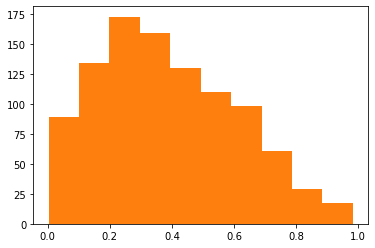

In [11]:
## simulate a generalized distribution
sim_n=1000
true_alpha,true_beta,true_loc,true_scale=1.4,2.2,0,1
sim_data = beta.rvs(true_alpha,true_beta,loc=true_loc,scale=true_scale,size=sim_n)
sim_bins2=plt.hist(sim_data)[1]
sim_probs2=plt.hist(sim_data)[0]/sim_n
sim_est=GeneralizedBetaEst(sim_bins2,sim_probs2)
sim_est

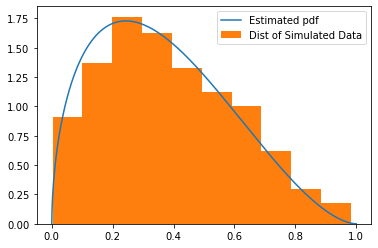

In [12]:
## plot the estimated generalized beta versus the histogram of simulated data drawn from a true beta distribution 
sim_x = np.linspace(true_loc,true_loc+true_scale,sim_n)
sim_pdf=beta.pdf(sim_x,sim_est[0],sim_est[1],loc=true_loc,scale=true_scale)
plt.plot(sim_x,sim_pdf,label='Estimated pdf')
plt.hist(sim_data,density=True,label='Dist of Simulated Data')
plt.legend(loc=0)

In [13]:
## This is the synthesized density estimation function
def SynDensityStat(bin,probs):
    """
    Synthesized density estimate module:
    It first detects the shape of histograms
    Then accordingly invoke the distribution-specific tool.
    
    paramters
    ---------
    bin:  ndarray, (n+1) x 1 
          positions for n bins in the histograms 
          
    probs:  ndarrray n x 1
          each entry is a probability for each of the n bins given by the surveyee, between 0 and 1
    
    returns
    -------
    moments: dict with 2 keys (more to be added in future)
            mean: empty or float, estimated mean 
            variance:  empty or float, estimated variance 
            std: empty or float, estimated standard deviation 
            irq1090: empty or float, estimated irq1090 
    
    """
    if sum(probs)==1:
        print("probs sum up to 1")
        ## Beta distributions 
        if sum([probs[i]>0 for i in range(len(bin)-1)])>=3:
            print("at least three bins with positive probs")
            para_est=GeneralizedBetaEst(bin,probs)
            if len(para_est)==4:
                print('4 parameters')
                return GeneralizedBetaStats(para_est[0],para_est[1],para_est[2],para_est[3])
            if len(para_est)==2:
                print('2 parameters')
                return GeneralizedBetaStats(para_est[0],para_est[1],0,1)
        ## Triangle distributions
        if sum([probs[i]>0 for i in range(len(bin)-1)])==2:
            #print("There are two bins with positive probs")
            pprobadj = [i for i in range(1,len(bin)-3) if probs[i]>0 and probs[i+1]>0]   # from 1 to -3 bcz excluding the open-ended on the left/right
            if sum(pprobadj)>0:
                #print('The two intervals are adjacent and not open-ended')
                para_est=TriangleEst(bin,probs)
                return TriangleStats(para_est['lb'],para_est['ub'])
        if sum([probs[i]>0 for i in range(len(bin)-1)])==1:
            print('Only one interval with positive probs')
            para_est= UniformEst(bin,probs)
            print(para_est)
            return UniformStats(para_est['lb'],para_est['ub'])
        else:
            return {"mean":[],"variance":[], "std":[], "irq1090":[]}
    else:
        return {"mean":[],"variance":[], "std":[], "irq1090":[]}

In [14]:
## testing the synthesized estimator function using an arbitrary example created above
SynDensityStat(sim_bins2,sim_probs2)['variance']

probs sum up to 1
at least three bins with positive probs
lower bound is 0.002657993901415366
upper bound is 0.9828155921835489
4 parameters


0.04836071809090586

In [19]:
### loading probabilistic data  
IndSPF=pd.read_stata('../data/sample_data.dta')   
# SPF inflation quarterly 
# 2 Inf measures: CPI and PCE
# 2 horizons: y-1 to y  and y to y+1

In [20]:
## survey-specific parameters 
nobs=len(IndSPF)
SPF_bins=np.array([-10,0,0.5,1,1.5,2,2.5,3,3.5,4,10])
print("There are "+str(len(SPF_bins)-1)+" bins in SPF")

There are 10 bins in SPF


In [26]:
len({'mean':1,'var':2})

2

In [30]:
##############################################
### attention: the estimation happens here!!!!!
###################################################

#IndSPF['PRCCPIMean0']='nan'   # CPI from y-1 to y 
#IndSPF['PRCCPIVar0']='nan'    
#IndSPF['PRCCPIMean1']='nan'  # CPI from y to y+1  
#IndSPF['PRCCPIVar1']='nan'
#IndSPF['PRCPCEMean0']='nan' # PCE from y-1 to y
#IndSPF['PRCPCEVar0']='nan'
#IndSPF['PRCPCEMean1']='nan' # PCE from y to y+1
#IndSPF['PRCPCEVar1']='nan'


## creating positions 
index  = IndSPF.index
columns=['PRCCPIMean0','PRCCPIVar0', 'PRCCPIMean1','PRCCPIVar1',
         'PRCPCEMean0','PRCPCEVar0','PRCPCEMean1','PRCPCEVar1']
IndSPF_moment_est = pd.DataFrame(index=index,columns=columns)

## Invoking the estimation

for i in range(nobs):
    print(i)
    ## take the probabilities (flip to the right order, normalized to 0-1)
    PRCCPI_y0 = np.flip(np.array([IndSPF.iloc[i,:]['PRCCPI'+str(n)]/100 for n in range(1,11)]))
    print(PRCCPI_y0)
    PRCCPI_y1 = np.flip(np.array([IndSPF.iloc[i,:]['PRCCPI'+str(n)]/100 for n in range(11,21)]))
    print(PRCCPI_y1)
    PRCPCE_y0 = np.flip(np.array([IndSPF.iloc[i,:]['PRCPCE'+str(n)]/100 for n in range(1,11)]))
    print(PRCCPI_y0)
    PRCPCE_y1 = np.flip(np.array([IndSPF.iloc[i,:]['PRCPCE'+str(n)]/100 for n in range(11,21)]))
    print(PRCCPI_y1)
    if not np.isnan(PRCCPI_y0).any():
        stats_est=SynDensityStat(SPF_bins,PRCCPI_y0)
        if len(stats_est)>0:
            IndSPF_moment_est['PRCCPIMean0'][i]=stats_est['mean']
            print(stats_est['mean'])
            IndSPF_moment_est['PRCCPIVar0'][i]=stats_est['variance']
            print(stats_est['variance'])
    if not np.isnan(PRCCPI_y1).any():
        stats_est=SynDensityStat(SPF_bins,PRCCPI_y1)
        if len(stats_est):
            print(stats_est['mean'])
            IndSPF_moment_est['PRCCPIMean1'][i]=stats_est['mean']
            print(stats_est['variance'])
            IndSPF_moment_est['PRCCPIVar1'][i]=stats_est['variance']
    if not np.isnan(PRCPCE_y0).any():
        if len(stats_est)>0:
            stats_est=SynDensityStat(SPF_bins,PRCPCE_y0)
            print(stats_est['mean'])
            IndSPF_moment_est['PRCPCEMean0'][i]=stats_est['mean']
            print(stats_est['variance'])
            IndSPF_moment_est['PRCPCEVar0'][i]=stats_est['variance']
    if not np.isnan(PRCPCE_y1).any():
        if len(stats_est)>0:
            stats_est=SynDensityStat(SPF_bins,PRCPCE_y1)
            print(stats_est['mean'])
            IndSPF_moment_est['PRCPCEMean1'][i]=stats_est['mean']
            print(stats_est['variance'])
            IndSPF_moment_est['PRCPCEVar1'][i]=stats_est['variance']

0
[0.  0.  0.  0.  0.  0.4 0.4 0.2 0.  0. ]
[0.  0.  0.  0.  0.2 0.5 0.3 0.  0.  0. ]
[0.  0.  0.  0.  0.  0.4 0.4 0.2 0.  0. ]
[0.  0.  0.  0.  0.2 0.5 0.3 0.  0.  0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is 2.0
upper bound is 3.5
2 parameters
0.42703989182291147
0.06107098995339946
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.5339485560023147
0.04583340869330193
[]
[]
[]
[]
1
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
2
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
3
[0.  0.  0.  0.  0.  0.2 0.7 0.1 0.  0. ]
[0.  0.  0.  0.  0.  0.2 0.6 0.2 0.  0. ]
[0.  0.  0.  0.  0.  0.2 0.7 0.1 0.  0. ]
[0.  0.  0.  0.  0.  0.2 0.6 0.2 0.  0. ]
[]
[]
probs

2 parameters
0.18698028916834367
0.008162126303860462
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 10.0
2 parameters
0.17195690513025785
0.007964211401123182
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 10.0
2 parameters
0.18698028916834367
0.008162126303860462
18
[0.   0.   0.01 0.09 0.26 0.35 0.27 0.02 0.   0.  ]
[0.   0.   0.   0.01 0.18 0.31 0.33 0.16 0.01 0.  ]
[0.   0.   0.01 0.09 0.26 0.35 0.27 0.02 0.   0.  ]
[0.   0.   0.   0.01 0.18 0.31 0.33 0.16 0.01 0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.5
2 parameters
0.5601491356508997
0.027094840015037574
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 4.0
2 parameters
0.49705454162716545
0.028402437357854228
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 4.0
2 parameters
0.461993356049421
0.02678

2 parameters
0.6000420717951156
0.03684152091257669
33
[0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
[0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
[0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
[0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
2.0
0.041666666666666664
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
2.0
0.041666666666666664
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
2.0
0.041666666666666664
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
2.0
0.041666666666666664
34
[0.  0.  0.  0.  0.  0.4 0.5 0.1 0.  0. ]
[nan nan nan nan nan nan nan nan nan nan]
[0.  0.  0.  0.  0.  0.4 0.5 0.1 0.  0. ]
[nan nan nan nan nan nan nan nan nan nan]
probs sum up to 1
at least three bins with positive probs
lower bound is 2.0
u

2 parameters
0.5329447837018215
0.02250029069585816
[]
[]
probs sum up to 1
at least three bins with positive probs
lower bound is 2.0
upper bound is 3.5
2 parameters
0.5329447837018215
0.02250029069585816
55
[0.   0.   0.   0.02 0.1  0.5  0.35 0.03 0.   0.  ]
[0.   0.   0.   0.05 0.25 0.35 0.3  0.05 0.   0.  ]
[0.   0.   0.   0.02 0.1  0.5  0.35 0.03 0.   0.  ]
[0.   0.   0.   0.05 0.25 0.35 0.3  0.05 0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
2 parameters
0.5563367179705149
0.01697894497551822
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
2 parameters
0.5119576718738615
0.03532688728425942
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
2 parameters
0.49999987323966616
0.04817954331215964
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
2 parameters
0.49999677577079626
0.0640564

2 parameters
0.2497965438576273
0.007403333704256657
70
[0.   0.   0.   0.   0.14 0.5  0.33 0.03 0.   0.  ]
[0.   0.   0.   0.01 0.22 0.37 0.33 0.06 0.01 0.  ]
[0.   0.   0.   0.   0.14 0.5  0.33 0.03 0.   0.  ]
[0.   0.   0.   0.01 0.22 0.37 0.33 0.06 0.01 0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.5
2 parameters
0.4388358223572651
0.027758961660961836
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 4.0
2 parameters
0.45639350536904405
0.022139655115118825
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
2 parameters
0.5086337741223341
0.018176208531230535
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 4.0
2 parameters
0.5612683764565464
0.013949895711798542
71
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan n

2 parameters
0.451447677676046
0.01701081339860428
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.5000016564930286
0.06615015788455103
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.5
2 parameters
0.43778567371045224
0.014294888250553613
[]
[]
85
[0.  0.  0.  0.  0.2 0.3 0.4 0.1 0.  0. ]
[0.   0.   0.   0.   0.3  0.25 0.25 0.2  0.   0.  ]
[0.  0.  0.  0.  0.2 0.3 0.4 0.1 0.  0. ]
[0.   0.   0.   0.   0.3  0.25 0.25 0.2  0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.5
2 parameters
0.4806127551865129
0.04858212269436265
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.5
2 parameters
0.4592289902942149
0.08190426985061229
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.46604885466652757
0.04583547859463797
probs sum

2 parameters
0.22881274457445402
0.003617394601571972
97
[0.  0.  0.  0.  0.1 0.4 0.4 0.1 0.  0. ]
[0.  0.  0.  0.1 0.4 0.4 0.1 0.  0.  0. ]
[0.  0.  0.  0.  0.1 0.4 0.4 0.1 0.  0. ]
[0.  0.  0.  0.1 0.4 0.4 0.1 0.  0.  0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.5
2 parameters
0.49999245279459364
0.03483981049615056
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
2 parameters
0.49999245279459364
0.03483981049615056
probs sum up to 1
at least three bins with positive probs
lower bound is 2.0
upper bound is 4.0
2 parameters
0.49999245279459364
0.03483981049615056
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.5
2 parameters
0.49999245279459364
0.03483981049615056
98
[0.   0.   0.   0.   0.35 0.5  0.15 0.   0.   0.  ]
[0.   0.   0.   0.   0.45 0.5  0.05 0.   0.   0.  ]
[0.   0.   0.   0.   0.35 0.5  0.15 0.   0.   0.  ]
[0.   0.   0.   0.  

2 parameters
0.4593622210211651
0.0381643379717277
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
2 parameters
0.38969718640736867
0.02283138427211334
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.5
2 parameters
0.488465504437781
0.0238783466223369
116
[0.   0.   0.   0.01 0.1  0.74 0.1  0.04 0.01 0.  ]
[0.   0.   0.01 0.02 0.17 0.48 0.19 0.09 0.03 0.01]
[0.   0.   0.   0.01 0.1  0.74 0.1  0.04 0.01 0.  ]
[0.   0.   0.01 0.02 0.17 0.48 0.19 0.09 0.03 0.01]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 4.0
2 parameters
0.42327340346003034
0.005385597320023136
[]
[]
[]
[]
[]
[]
117
[0.  0.  0.  0.  0.1 0.8 0.1 0.  0.  0. ]
[0.  0.  0.  0.  0.3 0.6 0.1 0.  0.  0. ]
[0.  0.  0.  0.  0.1 0.8 0.1 0.  0.  0. ]
[0.  0.  0.  0.  0.3 0.6 0.1 0.  0.  0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 para

2 parameters
0.49999926737357536
0.016602847456869668
129
[0.   0.   0.05 0.1  0.2  0.3  0.2  0.1  0.05 0.  ]
[0.   0.02 0.08 0.12 0.15 0.25 0.15 0.12 0.1  0.01]
[0.   0.   0.05 0.1  0.2  0.3  0.2  0.1  0.05 0.  ]
[0.   0.02 0.08 0.12 0.15 0.25 0.15 0.12 0.1  0.01]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 4.0
2 parameters
0.4999999503727329
0.03715441568314272
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 10.0
2 parameters
0.23119322485199342
0.008875372521951544
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 4.0
2 parameters
0.5159814824956075
0.02785879569439198
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 10.0
2 parameters
0.22014230881897548
0.0073647217485353945
130
[0.  0.  0.  0.  0.3 0.4 0.3 0.  0.  0. ]
[0.   0.   0.05 0.1  0.25 0.35 0.2  0.05 0.   0.  ]
[0.  0.  0.  0.  0.3 0.4 0.3 0.  0.  

4 parameters
2.2340907227822795
0.28336967695354426
[]
[]
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
2.2340907227822795
0.28336967695354426
[]
[]
146
[0.   0.   0.   0.   0.05 0.45 0.45 0.05 0.   0.  ]
[0.   0.   0.   0.05 0.45 0.45 0.05 0.   0.   0.  ]
[0.   0.   0.   0.   0.05 0.45 0.45 0.05 0.   0.  ]
[0.   0.   0.   0.05 0.45 0.45 0.05 0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.5
2 parameters
0.49999973347073623
0.022979669905026805
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
2 parameters
0.49999973347073623
0.022979669905026805
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.5
2 parameters
0.49999973347073623
0.022979669905026805
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
2 parameters
0.499999733470

2 parameters
0.5931501607484853
0.01472940731918965
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
2 parameters
0.49997967141229693
0.016198196210665577
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.0
2 parameters
0.5785293810705854
0.01848264591971449
165
[0.  0.  0.  0.  0.7 0.3 0.  0.  0.  0. ]
[0.   0.   0.01 0.05 0.4  0.45 0.08 0.01 0.   0.  ]
[0.  0.  0.  0.  0.7 0.3 0.  0.  0.  0. ]
[0.   0.   0.01 0.05 0.4  0.45 0.08 0.01 0.   0.  ]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
2.052758056251845
0.0509235781252197
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.5
2 parameters
0.5116238197228155
0.013057245272598949
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.40260175843821094
0.02337021186376635
probs sum up to 

/var/folders/39/ks6jc__9375c2fl7h7pwq5jh0000gn/T/ipykernel_6806/2215526983.py:16: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if lb!=[] and ub!=[]:


2 parameters
0.4999983888117568
0.013834495880680852
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.0
2 parameters
0.500001487633802
0.030241141472608934
177
[0.   0.   0.05 0.1  0.2  0.3  0.2  0.1  0.05 0.  ]
[0.   0.02 0.08 0.12 0.15 0.25 0.15 0.12 0.1  0.01]
[0.   0.   0.05 0.1  0.2  0.3  0.2  0.1  0.05 0.  ]
[0.   0.02 0.08 0.12 0.15 0.25 0.15 0.12 0.1  0.01]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 4.0
2 parameters
0.4999999503727329
0.03715441568314272
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 10.0
2 parameters
0.23119322485199342
0.008875372521951544
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 4.0
2 parameters
0.5159814824956075
0.02785879569439198
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 10.0
2 parameters
0.22014230881897548
0.00736472

/var/folders/39/ks6jc__9375c2fl7h7pwq5jh0000gn/T/ipykernel_6806/2215526983.py:16: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if lb!=[] and ub!=[]:


4 parameters
2.4252863535212157
0.25908218271924804
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
2.328800008354964
0.8702627413580825
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
996.2262204210788
-77.18375245233493
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
2.5885275844381077
0.5852864242960729
187
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
188
[0.   0.   0.   0.   0.1  0.65 0.25 0.   0.   0.  ]
[0.   0.   0.   0.   0.1  0.2  0.45 0.2  0.05 0.  ]
[0.   0.   0.   0.   0.1  0.65 0.25 0.   0.   0.  ]
[0.   0.   0.   0.   0.1  0.2  0.45 0.2  0.05 0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
2 parameters
0.54876

2 parameters
0.49999536111579357
0.03337473449588551
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
2.0
0.041666666666666664
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
2.052758056251845
0.0509235781252197
199
[0.02 0.03 0.04 0.1  0.2  0.35 0.18 0.05 0.02 0.01]
[0.01 0.03 0.05 0.16 0.2  0.3  0.14 0.06 0.03 0.02]
[0.02 0.03 0.04 0.1  0.2  0.35 0.18 0.05 0.02 0.01]
[0.01 0.03 0.05 0.16 0.2  0.3  0.14 0.06 0.03 0.02]
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
2.061847404687061
0.4840692117550715
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
2.039405484355889
0.5990622253481463
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0


KeyboardInterrupt: 

In [47]:
### exporting moments estimates to pkl
IndSPF_est = pd.concat([IndSPF,IndSPF_moment_est], join='inner', axis=1)
IndSPF_est.to_pickle("./DstSampleEst.pkl")
IndSPF_pk = pd.read_pickle('./DstSampleEst.pkl')

In [48]:
IndSPF_pk['PRCCPIMean0']=pd.to_numeric(IndSPF_pk['PRCCPIMean0'],errors='coerce')   # CPI from y-1 to y 
IndSPF_pk['PRCCPIVar0']=pd.to_numeric(IndSPF_pk['PRCCPIVar0'],errors='coerce')   
IndSPF_pk['PRCCPIMean1']=pd.to_numeric(IndSPF_pk['PRCCPIMean1'],errors='coerce')   # CPI from y to y+1  
IndSPF_pk['PRCCPIVar1']=pd.to_numeric(IndSPF_pk['PRCCPIVar1'],errors='coerce')

IndSPF_pk['PRCPCEMean0']=pd.to_numeric(IndSPF_pk['PRCPCEMean0'],errors='coerce')  # PCE from y-1 to y
IndSPF_pk['PRCPCEVar0']=pd.to_numeric(IndSPF_pk['PRCPCEVar0'],errors='coerce') 
IndSPF_pk['PRCPCEMean1']=pd.to_numeric(IndSPF_pk['PRCPCEMean1'],errors='coerce')  # PCE from y to y+1
IndSPF_pk['PRCPCEVar1']=pd.to_numeric(IndSPF_pk['PRCPCEVar1'],errors='coerce')

In [49]:
IndSPF_pk.tail()

,date,year,quarter,ID,INDUSTRY,PRCCPI1,PRCCPI2,PRCCPI3,PRCCPI4,PRCCPI5,...,PRCPCE20,PRCPCE_merge,PRCCPIMean0,PRCCPIVar0,PRCCPIMean1,PRCCPIVar1,PRCPCEMean0,PRCPCEVar0,PRCPCEMean1,PRCPCEVar1
2088,2019-01-01,2019.0,1.0,583.0,,0.00,0.00,0.00,0.0,70.00,...,NaN,matched (3),1.947242,0.050924,2.000000,0.041667,NaN,NaN,NaN,NaN
2089,2019-01-01,2019.0,1.0,584.0,,0.00,1.30,11.50,36.4,38.00,...,3.10,matched (3),0.498173,0.020278,2.512724,0.965724,0.520586,0.015981,1.871590,0.851250
2090,2019-01-01,2019.0,1.0,585.0,,0.00,0.00,0.00,10.0,60.00,...,0.00,matched (3),NaN,NaN,0.499999,0.031662,0.533949,0.045833,0.488048,0.035330
2091,2019-01-01,2019.0,1.0,586.0,,0.07,0.87,5.12,16.2,27.78,...,0.43,matched (3),NaN,NaN,2.003787,0.759800,NaN,NaN,1.705376,0.390075
2092,NaT,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,...,NaN,matched (3),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
IndSPF_pk.to_stata('../data/Dstsample_data.dta')

6 abnormals
167
-69.98106437076153
[0.   0.   0.   0.05 0.14 0.25 0.3  0.15 0.08 0.03]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 10.0
2 parameters
-69.98106437076153
213
-69.98106437076153
[0.   0.   0.   0.05 0.14 0.25 0.3  0.15 0.08 0.03]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 10.0
2 parameters
-69.98106437076153
214
-33.94734206578234
[0.   0.   0.   0.01 0.06 0.23 0.38 0.28 0.03 0.01]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 10.0
2 parameters
-33.94734206578234
347
-92.78429980074593
[0.   0.   0.   0.04 0.05 0.49 0.19 0.15 0.05 0.03]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 10.0
2 parameters
-92.78429980074593
445
-101.59524650854313
[0.   0.   0.   0.05 0.1  0.35 0.35 0.1  0.03 0.02]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 10.0

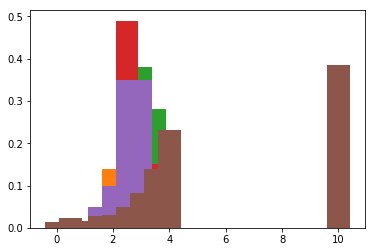

In [51]:
### Robustness checks: focus on big negative mean estimates 
sim_bins_data = SPF_bins
print(str(sum(IndSPF_pk['PRCCPIMean1']<-2))+' abnormals')
ct=0
figure=plt.plot()
for id in IndSPF_pk.index[IndSPF_pk['PRCCPIMean1']<-2]:
    print(id)
    print(IndSPF_pk['PRCCPIMean1'][id])
    sim_probs_data= np.flip(np.array([IndSPF['PRCCPI'+str(n)][id]/100 for n in range(11,21)]))
    plt.bar(sim_bins_data[1:],sim_probs_data)
    print(sim_probs_data)
    stats_est=SynDensityStat(SPF_bins,sim_probs_data)
    print(stats_est['mean'])